# Homework Module 1
The objective of this project is to train a simple model predicting the ride duration of For-Hire Vehicle Trip Records dataset.

## Q1. Downloading the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

* 1054112
* **1154112**
* 1254112
* 1354112

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import joblib

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
def load_dataset(path):
    """
    Return the dataset in pandas dataframe format with lowercase columns
    and each column name seperated by underscore.
    
    Args:
    * path, str: file directory or file link of dataset
    
    Output:
    * pd.DataFrame
    
    Notes:
    This function is used to read a parquet format.
    If the format is not parquet, change the first line of code.
    
    """
    df = pd.read_parquet(path)
    df.columns = [inflection.underscore(var) for var in list(df.columns)]    
    return df

train = load_dataset("../dataset/fhv_tripdata_2021-01.parquet")
val = load_dataset("../dataset/fhv_tripdata_2021-02.parquet")
train.shape, val.shape

((1154112, 7), (1037692, 7))

In [3]:
train.sample()

,dispatching_base_num,pickup_datetime,drop_off_datetime,p_ulocation_id,d_olocation_id,sr_flag,affiliated_base_number
1075577,B02794,2021-01-29 13:08:17,2021-01-29 13:39:20,NaN,67.0,None,B00385


There are **1154112** records in January 2021 dataset.

## Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

* 15.16
* **19.16**
* 24.16
* 29.16

In [4]:
def target_variable(df):
    """
    Return the target variable, which in this case is ride duration in minutes.
    duration = drop_off_datetime - pickup_datetime.
    
    Args:
    * df, pd.DataFrame: the dataset
    
    Output:
    * pd.DataFrame: contain the target variable
    """
    df['duration'] = df['drop_off_datetime'] - df['pickup_datetime']
    df['duration'] = df['duration'].dt.total_seconds() / 60
    return df

train = target_variable(train)
val = target_variable(val)

print(f"The average trip duration is {train['duration'].mean():.3f} minutes")

The average trip duration is 19.167 minutes


## Data preparation
Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

<AxesSubplot:>

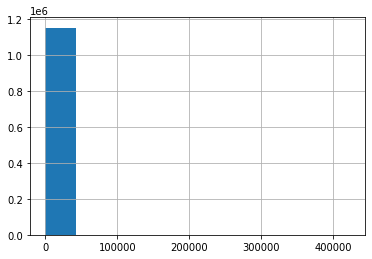

In [5]:
train['duration'].hist()

In [6]:
train_new = train[(train['duration'] >= 1) & (train['duration'] <= 60)].copy()
val_new = val[(val['duration'] >= 1) & (val['duration'] <= 60)].copy()

print(f"Total number of dropped records: {train.shape[0] - train_new.shape[0]} rows")

Total number of dropped records: 44286 rows


## Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

* 53%
* 63%
* 73%
* **83%**

In [7]:
train_new['p_ulocation_id'] = train_new['p_ulocation_id'].fillna(-1)
train_new['d_olocation_id'] = train_new['d_olocation_id'].fillna(-1)

val_new['p_ulocation_id'] = val_new['p_ulocation_id'].fillna(-1)
val_new['d_olocation_id'] = val_new['d_olocation_id'].fillna(-1)

missing_val = train_new['p_ulocation_id'][train_new['p_ulocation_id'] == -1]
print(f"fractions of missing values for the pickup location ID: {100 * missing_val.shape[0] / train_new['p_ulocation_id'].shape[0]:.2f}%")

fractions of missing values for the pickup location ID: 83.53%


## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

* 2
* 152
* 352
* **525**
* 725

In [8]:
X_train = train_new[['p_ulocation_id', 'd_olocation_id']].astype(str).copy()
X_val = val_new[['p_ulocation_id', 'd_olocation_id']].astype(str).copy()

X_train = X_train.to_dict(orient='records')
X_val = X_val.to_dict(orient='records')

dt = DictVectorizer()
X_train = dt.fit_transform(X_train)
X_val = dt.transform(X_val)

y_train = train_new['duration'].values
y_val = val_new['duration'].values

X_train.shape

(1109826, 525)

The dimensionality of this matrix: **525 columns**

## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?

* 5.52
* **10.52**
* 15.52
* 20.52

In [9]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print(f"RMSE of the model on the training data: {rmse:.2f}")

RMSE of the model on the training data: 10.53


## Q6. Evaluating the model
Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

* 6.01
* **11.01**
* 16.01
* 21.01

In [10]:
y_pred_val = reg.predict(X_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
print(f"RMSE of the model on the validation data: {rmse:.2f}")

RMSE of the model on the validation data: 11.01
